#Name: Nausherwan Khan
#id: 180463554
#Email: ec18263@qmul.ac.uk

# Music Generation using Convolutional Neural Networks 
This is a research-based Final Year project that deals with creating a generative model for music. The proposal of this project is novel and has not been published anywhere yet. I believe it can improve the way Deep Learning models are being used to train not only musical data but any temporal data with lower dimensional resolution.

#Connecting to Google Drive



> Google drive is used as the storage for the input and output files.

> If the notebook is being accessed through Jupyter, we do not need to mount the google drive.











In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Installing required packages



> pretty_midi is a Python library created to read and write MIDI files. The music is represented as Pretty_Midi objects which have a sequence of instruments and notes. Pretty_midi library also provides two of the most useful functions for this projects, which are converting a midi_sequence to a piano_roll and converting the piano_roll back into a pretty_midi. 


> Link to the repository: https://github.com/craffel/pretty-midi







In [2]:
!pip install pretty-midi

     |████████████████████████████████| 5.6 MB 3.4 MB/s 
     |████████████████████████████████| 51 kB 9.7 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=9cbd330e78f64689fecab1d0f863dead05181110f45e483874f9c7aa8de66768
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


#Importing libraries and functions

In [4]:
import glob
import pretty_midi
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, Add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Setting sampling frequency, fs=32 
* Sampling Frequency: **fs=32**
* Implementation of the piano_roll_to_pretty_midi method, which is just a placeholder for this project and can be replaced by a more efficient function to get better results. The resolution of out outputs is still good enough for this method to work properly as the velocity and musical note information is more densely packed.

In [5]:
#Setting sampling frequency to a constant value
fs = 32

In [6]:
"""
Utility function for converting an audio file
to a pretty_midi.PrettyMIDI object. Note that this method is nowhere close
to the state-of-the-art in automatic music transcription.
"""
from __future__ import division
import sys
import argparse
import numpy as np
import pretty_midi
import librosa
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


#Creating and Testing the "Dynamic" music dataset
A smaller Dynamic dataset is used for training due to limited RAM capacity. The dataset used for training is formed of pieces takes from Beethoven, Chopin, and Liszt. The pieces are short midi clips of the compositions that represent some of the most Dynamic features of Piano music as expressed by the above-mentioned composers.


In [ ]:
'''    Creating a function that gets all the midi
       tracks and returns a piano-roll numpy array 
       with all the tunes horizontally stacked
'''

def get_piano_roll_all(file_name='/content/gdrive/MyDrive/FYP/midi_files/midi_dataset/', fs=fs):
  piano_roll = np.zeros((128, 1)) #starting point of the giant-piano-roll
  interval_piano_roll = np.zeros((128, 16)) #time interval between two different tracks
  for file in glob.glob(file_name + '*.mid'):
    beeth = pretty_midi.PrettyMIDI(midi_file=file)
    beeth_pr = beeth.get_piano_roll(fs=fs)
    piano_roll = np.hstack((piano_roll, beeth_pr, interval_piano_roll))
  piano_roll = np.where(piano_roll > 127, 127, piano_roll)
  return piano_roll.astype(np.uint8)
  

In [ ]:
'''
        Getting all the training set in a giant piano-roll (to be batched),
        and a list of all the files in pretty_midi format as a list.
        Also saving a sample as a sanity check
'''
piano_roll_all = get_piano_roll_all(file_name='/content/gdrive/MyDrive/FYP/midi_files/dynamic_midis/', fs=fs)
print(f'Shape of Piano-Roll: {piano_roll_all.shape}')

Shape of Piano-Roll: (128, 4530)


In [ ]:
sample_size = 4530 # 30 seconds piece for fs=32
start_index = 20
sample_pretty_midi_generated = piano_roll_to_pretty_midi(piano_roll_all[:, start_index : start_index + sample_size], fs=fs)
sample_pretty_midi_generated.write('/content/gdrive/My Drive/FYP/sample_dynamic_output.mid')
print('Sample generated in My Drive!')


Sample generated in My Drive!


In [ ]:
np.max(piano_roll_all)

127

In [ ]:
'''    This splits the dataset into separate instruments and saves each instrument as a midi file, for analysis.    '''
# def create_instruments():
#   for i in range(1,27):
#     beeth = pretty_midi.PrettyMIDI(midi_file=f'/content/gdrive/MyDrive/FYP/midi_files/midi_dataset/b{i}.mid')
#     print(beeth.get_piano_roll.shape)
#     for instr in beeth.instruments:
#       new_instr = pretty_midi.Instrument(program=0, is_drum=False, name=instr.name)
#       new_instr.notes = instr.notes
#       new_midi = pretty_midi.PrettyMIDI()
#       new_midi.instruments.append(new_instr)
#       new_midi.write(f'/content/gdrive/MyDrive/FYP/midi_files/instruments_files/b{i}_{instr.name.replace(" ", "")}.mid')

'    This splits the dataset into separate instruments and saves each instrument as a midi file, for analysis.    '

In [ ]:
'''    testing difference between original midi piano roll and instrument-wise piano-roll    '''

# orig_mid = pretty_midi.PrettyMIDI(midi_file='/content/gdrive/MyDrive/FYP/midi_files/midi_dataset/b1.mid')
# orig_pr = orig_mid.get_piano_roll()
# inst_1_pr = orig_mid.instruments[0].get_piano_roll()
# inst_2_pr = orig_mid.instruments[1].get_piano_roll()
# print(np.sum(orig_pr - inst_1_pr - inst_2_pr))

'    testing difference between original midi piano roll and instrument-wise piano-roll    '

In [ ]:
# note = piano_roll_all[:,234]
# note2d = khanspan_1D_to_2D(note)
# print(note.nonzero(), note2d.nonzero())
# note_zeros = np.zeros((128,128))
# note_zeros[note2d.nonzero()] = 1
# print(note_zeros.nonzero())
# note_returns = khanspan_2D_to_1D(note_zeros)
# print(note_returns.nonzero())

# Converting 1D representation of the Piano-roll to a 2D representation

* This section is very crucial as it takes the whole piano_roll, converts it into the two-dimensional representation and saves it to the drive as a numpy matrix.

* **khanspan_1D_to_2D:** Converts a single (128,) shaped note to (128,128) shaped binary node.
* **khanspan_2D_to_1D:** Converts the 2D note back into a 1D note for recreating the output from the Convolutional Neural Network Model.
* **convert_piano_roll_1D_to_2D:** Takes the massive 1D piano-roll, and the filename to be written to, as arguments. Uses the GPU optimized function apply_along_axis of the NumPy library to convert the whole piano-roll to the 2D representation using khanspan_1D_to_2D. 
Note: This has to be done only once as the 2D dataset gets saved and can be simply loaded from the drive or the local storage, depending on the platform.



In [7]:
'''
Functions for transforming single note representations between 1D and 2D
These funcitons take a note with shape (128,) and convert to (128,128) representing pitch and velocity respectively,
and vice versa
'''
def khanspan_1D_to_2D(note_1D):
  note_2D = np.zeros((128,128))
  pitches = np.nonzero(note_1D)
  note_2D[pitches, note_1D[pitches]] = 1
  return note_2D.astype(np.uint8)

def khanspan_2D_to_1D(note_2D):
  note_1D = np.zeros((128,))
  for pitch in range(128):
    note_1D[pitch] = np.argmax(note_2D[pitch]) #gettin velocity from 2D array
  return note_1D.astype(np.uint8)

In [8]:
'''
Method that converts the massive piano-roll (128, number of frames) 
to a piano-roll with shape (128, 128, number of frames) 
with notes in the transformed 2D shape
'''
def convert_piano_roll_1D_to_2D(piano_roll_1D, filename="/content/gdrive/My Drive/FYP/numpy_datasets/default_dataset_2D.npy"):
  music_dataset_2D = np.apply_along_axis(khanspan_1D_to_2D, 0, piano_roll_1D).astype(np.uint8)
  np.save(filename, music_dataset_2D) 
  return music_dataset_2D

In [ ]:
# music_dataset_2D = convert_piano_roll_1D_to_2D(piano_roll_all, 
#                                                filename="/content/gdrive/My Drive/FYP/numpy_datasets/dynamic_dataset_2D.npy")

In [ ]:
music_dataset_2D = np.load("/content/gdrive/My Drive/FYP/numpy_datasets/dynamic_dataset_2D.npy") #saved at fs=32

In [ ]:
# music_dataset_2D = music_dataset_2D[..., 0:200000]
print(f"Piano-roll 2D shape: {music_dataset_2D.shape}")

Piano-roll 2D shape: (128, 128, 4530)


#Creating labels and features from the 2D dataset
* **split_to_sequences:** Converts the 2D dataset into batches of fixed sequence_length provided as the argument. By default the sequence_length is 96 which represents 3 seconds at sampling rate of 32. It also creates the input and output labels for training. You have the power to set the size of the output labels as well, and the "stride" argument can be used to control the overlapping.
The input and output datasets are saved to the Drive as .npy files, so loading is quicker after the first, and it prevents the RAM from crashing. 

* **X_train:** Shape, (num_samples, 128, 128, sequence_length)
* **y_train:** Shape, (num_samples, 128, 128, 1)

In [ ]:
'''
This function splits the 2D dataset into  sequences with a fixed length, to be later used to train the Convolution layers.
Converts the input datasetwith shape (128,128,total_length) to (number_of_sequences, 128, 128, sequence_length)
'''
def split_to_sequences(dataset_2D, sequence_length=96, output_length=1, stride=1):
  starting_point = 0
  X_data = np.zeros((1,128,128,sequence_length), dtype=np.uint8)
  y_data = np.zeros((1,128,128,output_length), dtype=np.uint8)
  while starting_point < dataset_2D.shape[-1] - sequence_length - output_length:
    X = dataset_2D[np.newaxis, :, :, starting_point: starting_point + sequence_length]
    y = dataset_2D[np.newaxis, :, :, starting_point + sequence_length : starting_point + sequence_length + output_length]
    starting_point += stride
    X_data = np.concatenate((X_data, X), axis=0)
    y_data = np.concatenate((y_data, y), axis=0)
  np.save("/content/gdrive/My Drive/FYP/numpy_datasets/X2_data.npy", X_data)
  np.save("/content/gdrive/My Drive/FYP/numpy_datasets/y2_data.npy", y_data)
  return (X_data, y_data)


In [ ]:
# (X_dataset, y_dataset) = split_to_sequences(music_dataset_2D,
#                                             sequence_length=96, 
#                                             output_length=1, 
#                                             stride=1)

In [ ]:
X_dataset = np.load("/content/gdrive/My Drive/FYP/numpy_datasets/X2_data.npy")
y_dataset = np.load("/content/gdrive/My Drive/FYP/numpy_datasets/y2_data.npy")

In [ ]:
print(f"X_dataset shape: {X_dataset.shape}")
print(f"y_dataset shape: {y_dataset.shape}")

X_dataset shape: (4434, 128, 128, 96)
y_dataset shape: (4434, 128, 128, 1)


In [ ]:
#Reshaping the X_dataset and y_dataset to (number_of_sequences, sequence_length, 128, 128, 1)

X_train = X_dataset#[:-904, ...]
y_train = y_dataset#[:-904, ...]

#Clear space by deleting unformated datasets
del X_dataset
del y_dataset

In [ ]:
print(f"Training input shape: {X_train.shape}")
print(f"Training output shape: {y_train.shape}")

Training input shape: (4434, 128, 128, 96)
Training output shape: (4434, 128, 128, 1)


#Creating the Convolutional Neural Network Model (MuResConvNet25)

* **create_model:** Creates the MuResConvNet25 model using the input_shape as argument. Compiles the model using,                                                        

 **Optimizer:** Adam optimizer

 **Loss:** Binary Cross-Entropy (since output data is binary)

 **Metrics:** Accuracy (Not very insightful)



In [9]:
'''
    Function creates the model, compiles it, and returns it.
    Takes input_shape=(sequence_length, 128, 128, 1) as input
'''
def create_model(input_shape):
  inp_layer = Input(shape=input_shape, name='input_layer')

  conv1 = Conv2D(filters=256, kernel_size=3, padding="same", activation='relu')(inp_layer)
  conv2 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(conv1)
  conv3 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(conv2)
  conv4 = Conv2D(filters=256, kernel_size=3, padding="same", activation='relu')(conv3)

  conv5 = tf.keras.layers.Add()([conv1, conv4])

  conv6 = Conv2D(filters=256, kernel_size=3, padding="same", activation='relu')(conv5)
  conv7 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(conv6)
  conv8 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(conv7)
  conv9 = Conv2D(filters=256, kernel_size=3, padding="same", activation='relu')(conv8)

  conv10 = tf.keras.layers.Add()([conv9, conv6, conv5])

  conv11 = Conv2D(filters=256, kernel_size=3, padding="same", activation='relu')(conv10)
  conv12 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(conv11)
  conv13 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(conv12)
  conv14 = Conv2D(filters=256, kernel_size=3, padding="same", activation='relu')(conv13)

  conv15 = tf.keras.layers.Add()([conv14, conv11, conv10])

  conv16 = Conv2D(filters=256, kernel_size=3, padding="same", activation='relu')(conv15)
  conv17 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(conv16)
  conv18 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(conv17)
  conv19 = Conv2D(filters=256, kernel_size=3, padding="same", activation='relu')(conv18)

  conv20 = tf.keras.layers.Add()([conv19, conv16, conv15])

  conv21 = Conv2D(filters=256, kernel_size=3, padding="same", activation='relu')(conv20)
  conv22 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(conv21)
  conv23 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(conv22)
  conv24 = Conv2D(filters=256, kernel_size=3, padding="same", activation='relu')(conv23)

  conv25 = tf.keras.layers.Add()([conv24, conv21, conv20])
  


  out_layer = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(conv25)

  model = Model(inputs=inp_layer, outputs=out_layer)
  #compiling model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 9  0           []                               
                                6)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 25  221440      ['input_layer[0][0]']            
                                6)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 51  1180160     ['conv2d[0][0]']                 
                                2)                                                            

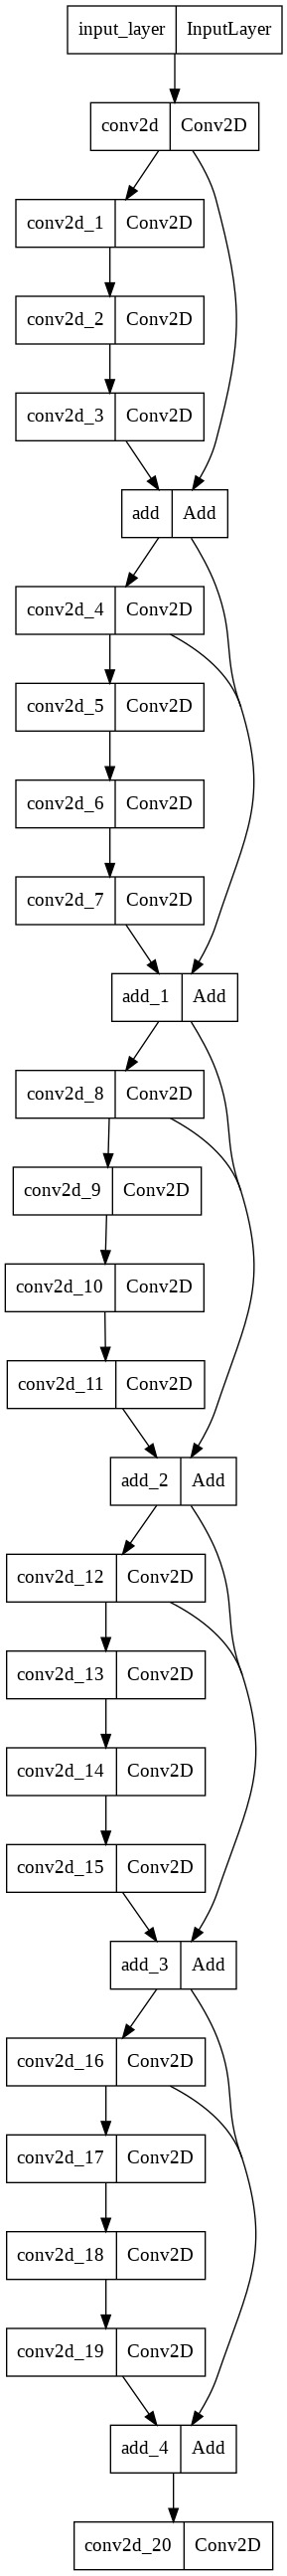

In [ ]:
model = create_model(X_train.shape[1:])
model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
#Fit and train the model
batch_size = 4
epochs = 10
cp_path = '/content/gdrive/MyDrive/FYP/model_checkpoints/ckpt'
checkpoint = ModelCheckpoint(filepath=cp_path,
                             monitor='loss',
                             save_best_only=True,
                             save_weights_only=True,
                             )
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(X_train*255, 
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[checkpoint, early_stopping]
                    )

Epoch 1/10
998/998 [==============================] - 1426s 1s/step - loss: 0.4117 - accuracy: 0.9997 - val_loss: 4.8272e-04 - val_accuracy: 0.9999
Epoch 2/10
998/998 [==============================] - 1416s 1s/step - loss: 3.6389e-04 - accuracy: 1.0000 - val_loss: 4.4686e-04 - val_accuracy: 0.9999
Epoch 3/10
998/998 [==============================] - 1413s 1s/step - loss: 3.1752e-04 - accuracy: 1.0000 - val_loss: 4.2873e-04 - val_accuracy: 0.9999
Epoch 4/10
998/998 [==============================] - 1411s 1s/step - loss: 3.0881e-04 - accuracy: 1.0000 - val_loss: 4.7488e-04 - val_accuracy: 1.0000
Epoch 5/10
998/998 [==============================] - 1410s 1s/step - loss: 2.9004e-04 - accuracy: 1.0000 - val_loss: 4.5174e-04 - val_accuracy: 1.0000


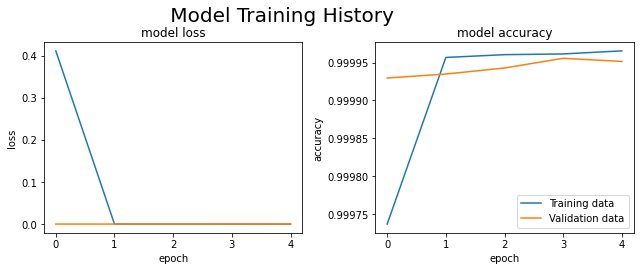

In [ ]:
'''    Plot the model training history   '''

fig, (ax_loss, ax_acc) = plt.subplots(1,2)
fig.suptitle("                      Model Training History", fontsize=20)
# history of accuracy
a11 = ax_acc.plot(history.history['accuracy'])
a12 = ax_acc.plot(history.history['val_accuracy'])
ax_acc.set_title('model accuracy')
ax_acc.set_ylabel('accuracy')
ax_acc.set_xlabel('epoch')

# history of loss
a21 = ax_loss.plot(history.history['loss'])
a22 = ax_loss.plot(history.history['val_loss'])
ax_loss.set_title('model loss')
ax_loss.set_ylabel('loss')
ax_loss.set_xlabel('epoch')

plt.legend(labels=["Training data", "Validation data"], loc="lower right")

fig.tight_layout(rect=[0, 0.05, 1.5, 0.95])
plt.show()

# Generate Music Using the Pre-Trained Model
* **get_clipped_pitches:** Clips the end pitches from the output note to make it more audibly pleasing. We can experiment with different acceptable ranges to get interesting results.
* **generate_music:** The most exciting function of this project. It used a 3 second sequence of music as input and uses it to iteratively build a composition. The threshold for the prediction can be changed and played with, to get infinitely many varying compositions, and select from among them.
It takes in arguments of the input and putput file. I have created a directory of input files for testing and obtaining resulting samples. You can experiments with these and those of your own choosing as well. 
We can even specify the length of the output sequence.
This method keeps printing the total number of pitches predicted at each cross-section of the roll, which helps us analyse the ability of the predictor.

In [10]:
'''
    This method clips the "bad-sounding" frequencies for the range of pitches specified
'''
def get_clipped_pitches(note, starting_pitch=33, ending_pitch=96):
  '''
  note is NumPy array with shape: (1, 128, 128, 1) representing (_, pitch, velocity, _)
  '''
  clipped_note = np.zeros(note.shape, dtype=np.uint8)
  clipped_note[0, starting_pitch:ending_pitch+1, :, 0] = note[0, starting_pitch:ending_pitch+1, :, 0]
  return clipped_note

In [11]:
'''
    Create a generative algorithm for obtaining a sequence of concatenated outputs from a sequence of input
'''
def generate_music(model, input_filename='/content/gdrive/My Drive/FYP/midi_files/test_inputs/test_input_1.mid', output_filename='/content/gdrive/My Drive/FYP/midi_files/test_outputs/test_output_2.mid', fs=fs, sequence_length=96, out_frames=500, threshold = 0.3):
  input_mid = pretty_midi.PrettyMIDI(midi_file=input_filename)
  input_pr = input_mid.get_piano_roll(fs=fs).astype(np.uint8) #getting piano-roll of input midi (128, timesteps)
  input_2D = convert_piano_roll_1D_to_2D(input_pr, input_filename) #2D dataset (128, 128, timesteps)
  input_sequence = input_2D[np.newaxis, ... , -sequence_length:] #shape: (1, 128, 128, sequence_length)
  conv_input = input_sequence #2d input, shape: (1, 128, 128, sequence_length)
  output_pr = np.zeros((128,1), dtype=np.uint8)
  for i in range(out_frames):
    pred_out_2D = model.predict(conv_input*255) #shape: (1, 128, 128, out_len)
    pred_out_2D = get_clipped_pitches(np.uint8(pred_out_2D > threshold))
    print(np.sum(pred_out_2D))
    input_sequence = np.concatenate((input_sequence, pred_out_2D), axis=-1)
    conv_input = np.concatenate((conv_input, pred_out_2D), axis=-1) #shape: (1, 128, 128, seq_len + out_len)
    conv_input = conv_input[..., pred_out_2D.shape[-1]:] #shape: (1, 128, 128, seq_len)
    for j in range(pred_out_2D.shape[-1]):
      pred_out_1D = khanspan_2D_to_1D(pred_out_2D[0,..., j]).reshape(128,1)
      output_pr = np.concatenate((output_pr, pred_out_1D), axis=-1)
  input_pr = np.concatenate((input_pr[:, -sequence_length:], output_pr), axis=-1)
  output_midi = piano_roll_to_pretty_midi(input_pr, fs=fs/4, program=0)   ###CAN BE SWAPPED WITH A BETTER FUNCTION IF AVAILABLE
  output_midi.write(filename=output_filename)
  return input_pr

In [12]:
'''
    Create model and load pre-trained weights
'''
sequence_length = 96
input_shape = (128, 128, sequence_length)
cp_path = '/content/gdrive/MyDrive/FYP/model_checkpoints/ckpt'
new_model = create_model(input_shape)
new_model.load_weights(cp_path)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 9  0           []                               
                                6)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 25  221440      ['input_layer[0][0]']            
                                6)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 51  1180160     ['conv2d[0][0]']                 
                                2)                                                            

In [14]:
#Actually generating the music using predictions from the trained model
out_seq = generate_music(new_model,
                         input_filename='/content/gdrive/My Drive/FYP/midi_files/test_inputs/test_input_4.mid',
                         output_filename='/content/gdrive/My Drive/FYP/midi_files/test_outputs/test_output_pending_decision.mid',
                         sequence_length=96,
                         out_frames=450,
                         threshold=0.05)

3
3
3
3
3
3
3
5
5
6
7
7
7
6
6
6
5
5
6
6
6
5
5
6
6
6
5
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
7
6
6
6
6
6
6
6
7
7
7
7
6
6
5
4
4
4
4
4
4
4
4
4
4
3
4
4
4
5
5
5
5
5
6
6
6
6
6
6
6
7
7
7
8
7
8
8
8
7
7
7
7
6
6
6
6
6
8
7
7
6
6
6
6
6
7
7
7
7
7
7
7
7
7
8
8
8
9
9
9
9
9
9
9
8
9
9
9
9
9
9
10
10
10
10
10
10
10
10
11
11
12
12
13
13
14
14
13
13
13
12
12
12
11
11
11
10
8
9
9
10
11
10
7
8
8
7
7
6
5
6
7
6
8
9
9
9
9
9
8
8
7
7
7
9
9
9
8
9
9
9
10
11
10
10
10
9
9
9
11
13
12
13
11
11
10
7
8
11
11
11
12
12
12
12
9
10
9
9
8
6
7
9
10
11
12
13
13
13
14
14
12
10
10
9
10
11
12
11
10
11
10
12
11
8
6
7
9
9
9
9
10
11
11
10
9
10
9
8
9
9
9
9
9
9
6
7
6
6
5
6
7
7
7
8
6
7
6
5
5
4
5
5
7
7
5
6
7
6
6
6
6
7
9
9
9
8
7
7
6
6
6
8
8
10
9
9
11
9
9
8
8
8
8
7
6
7
7
6
7
7
7
7
6
6
7
7
6
5
5
4
4
4
6
6
7
7
5
4
5
5
4
4
5
4
4
5
4
5
5
5
5
4
4
4
4
4
6
6
7
7
7
6
6
7
8
6
5
6
7
7
7
7
7
7
7
6
6
7
7
7
7
7
7
7
8
8
6
6
6
7
7
7
6
6
6
6
6
7
7
7
7
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
6
6
6
6
6
5
6
5
5
5
5
5
5
5
5
6
6
6
6
6
6
5
5


In [ ]:
print(np.sum(out_seq))

336086


In [ ]:
output_pr = generate_music(new_model, out_frames=50)

#output_midi = piano_roll_to_pretty_midi(output_pr, fs=fs, program=0)
#output_midi.write('/content/gdrive/My Drive/FYP/midi_files/test_outputs/test_output_1.mid')

In [ ]:
'''
    Create test input files
'''
def create_test_files(filename='/content/gdrive/My Drive/FYP/midi_files/test_inputs/test_input_2.mid', input_filename='/content/gdrive/My Drive/FYP/midi_files/test_dataset/beeth_test_3.mid', fs=fs, start_index=100):
  midi_file = pretty_midi.PrettyMIDI(midi_file=input_filename)
  midi_pr = midi_file.get_piano_roll(fs=fs)
  midi_pr = midi_pr[:, start_index:start_index+1000]
  new_midi_file = piano_roll_to_pretty_midi(midi_pr, fs=fs, program=0)
  new_midi_file.write(filename)

In [ ]:
create_test_files(filename='/content/gdrive/My Drive/FYP/midi_files/test_inputs/test_input_15.mid',fs=fs, start_index=3400)

# Dynamic dataset file

In [ ]:
#chopin
dyn_interval = np.zeros((128, 16), dtype=np.uint8)
dyn_filename = "dynamic_waltz"
dyn_path = f"/content/gdrive/My Drive/FYP/midi_files/dynamic_midis/{dyn_filename}.mid" 
chopin_mid = pretty_midi.PrettyMIDI(midi_file=dyn_path)
chopin_pr = chopin_mid.get_piano_roll(fs=fs)
cropped_chopin_pr = np.concatenate((chopin_pr[:, 1312:1792], dyn_interval, chopin_pr[:, 3296:3776]), axis=-1)
dyn_midi_out = piano_roll_to_pretty_midi(cropped_chopin_pr, fs=fs, program=0)
dyn_midi_out.write("/content/gdrive/My Drive/FYP/midi_files/dynamic_midis/dyn4.mid") 
print(cropped_chopin_pr.shape)

(128, 961)
